In [1]:
# Web scrapying
from bs4 import BeautifulSoup # modulo de BeautifulSoup
import requests
import ssl
import json

# Data manipulation
import pandas as pd
import numpy as np

# Spyding

The idea is to gather data from the web. We need to first select a web (and its [URL](https://psdeals.net/tr-store)) to extract the data. We need info regarding the price of a game in the Turkey store. At the very beginning, we'll use [this website](https://psdeals.net/tr-store) to construct the data.

In this first step, we will analyze how the website is constructed and how we can obtain mainly the price and the name of the game that we search for.


## Step 1: The URL

Doing the search. In this case let's create a tool to search an specific term in the web. Let's suppose that we are interested in searching the name of the game God of War. The main page looks like this:

<img src="../pics/main page.png" alt="Main Page" width="500"/>

But, after we do a search this is the result. Now we need to look at the structure of the URL created to do the search.

<img src="../pics/search-page.png" alt="Search Page" width="500"/>

This means that the url has an standard search ith aprameters added. The standard urls is something like `https://psdeals.net/tr-store/search?search_query=` and the searched item is added to the url separed by a "+" symbol. 

So, with that in mind...


In [2]:
# let's create a function to generate URLs of the games that we want to search
def search_games():
    """
    Generates search URLs for the given items.

    Args: 
        None. The games' names are provided by the user through the console.

    Returns:
        List[str]: A list of URLs to search for the specified games.
    """
    items = []
    game = input("Insert a game (or press enter to finish): ")
    while game != "":
        items.append(game)
        game = input("Insert a game (or press enter to finish): ")

    # Generating URLs to search :D
    base_url = "https://psdeals.net/tr-store/search?search_query="
    urls = [base_url + i.replace(" ", "+") for i in items]

    print("You asked for: {}".format(", ".join(items)))
    return urls

urls = search_games()
print(urls)



You asked for: hjjjk
['https://psdeals.net/tr-store/search?search_query=hjjjk']


# Step 2: The Soup

Now that we have the URLs, we can extract the data from the pages.

For this step, we will use the `requests` library to fetch the pages and the `BeautifulSoup` library to parse the HTML.

First, we need to install the required libraries. If you dont have them well... Go on! Do it, and then i'll illustrate you my dear commrade. 

With that being said, let us cook a beautiful Soup!

In [3]:
# With only 1 URL: Just to get 
url = urls[0]
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}
r = requests.get(url, headers=headers)
print("Status code:", r.status_code)
print("Encoding:", r.encoding)
soup = BeautifulSoup(r.text, "lxml")

Status code: 200
Encoding: UTF-8


well, we have now a page woth all the data regarding the search. If we look at the "soup"; we have all the ingredients but is kinda messy to understand due the "html" format. indeed, if we look at a general idea of the html code of the full page we would find hard to unedrstand all formats and where to search.

A pretty useful tactic is to identify a portion of what we are looking for wihtihn the webpage and then try to figure out (more or less) where is the info that we are looking for (price and game name).

<img src="../pics/web inspection.png" alt="Search Page" width="500"/>

If we look at the inspect parameter in the web browser, we discover that game price is somehow within a tag called "dev" with differentes classes. Now this is a child tag from a parent tag called "div" with class "ga,e-collection-item-details-title"

So a very good first step is to look out in this section. Let's see what we can find there....

In [4]:
soup.find_all("div", class_= "game-collection-item")

[]

I gotta be honest. I cant see a shit here. So lets write this as a txt file and then, we wil format it as a propper html. 

In [5]:
tags_txt = soup.find_all("div", class_="game-collection-item")
tags_html_combined = "\n".join(str(tag) for tag in tags_txt)
with open("games_tags.html", "w", encoding="utf-8") as file:
    file.write(tags_html_combined)


And guess what? We discovered something interesting...

<img src="../pics/findinf game.png" alt="Search Page" width="700"/>

We discovered now that the order is more or less like this:

div class "game-collection-tiem item": This would be the parent class with all the game's data.

div class "game-collection-item-details-title" : This would be a son class of the later class, this would have info regarging the game's title.

div class "game-collecyion-item-price": This would be a son of the first class and a sibling class of the later one, this has info regarding the **price** 

With the same idea, we can look for the game's platform and collect the data. I invite you to find out where is it and discovere it by yourself! (ok, ok, ill confess it, i forgot to take the screenshots and i am too lazy to do the search and all that. But ill give you a hint, is a parent class of the bigger class that i listed before)

With all bieng said, now we cand do the magic! let's collect the data of the games that we look for!



In [6]:
products = soup.find_all('div', class_='game-collection-item')
product_details = []
for product in products:

    name_tag = product.find('span', class_='game-collection-item-details-title')

    price_tag = product.find('span', class_='game-collection-item-price')

    platform_tag = product.find('span', class_='game-collection-item-top-platform')
    
    if name_tag and price_tag and platform_tag:
        name = name_tag.get_text(strip=True)  
        price = price_tag.get_text(strip=True) 
        platform = platform_tag.get_text(strip=True)  
        product_details.append((name, price, platform))  
product_details
    

[]

# Generalazing the problem

Now we know how to properly capture info, we want know to do this with every single game that the user has input, this is basically to replicate the process all the time needed. First, let's ensure that we can do this with every single URL (this means, the methos is scallable and not onyl works with the first url we used)

In [7]:
url = urls[1]
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}
r = requests.get(url, headers=headers)
print("Status code:", r.status_code)
print("Encoding:", r.encoding)
soup = BeautifulSoup(r.text, "lxml")

product_details = []

products = soup.find_all('div', class_='game-collection-item')

for product in products:

    name_tag = product.find('span', class_='game-collection-item-details-title')
    price_tag = product.find('span', class_='game-collection-item-price')
    platform_tag = product.find('span', class_='game-collection-item-top-platform')

    if name_tag and price_tag and platform_tag:
        name = name_tag.get_text(strip=True)  
        price = price_tag.get_text(strip=True)  
        platform = platform_tag.get_text(strip=True)  
        product_details.append((name, price, platform))  

product_details

IndexError: list index out of range

# URL 3


In [ ]:
url = urls[2]
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}
r = requests.get(url, headers=headers)
print("Status code:", r.status_code)
print("Encoding:", r.encoding)
soup = BeautifulSoup(r.text, "lxml")

product_details = []


products = soup.find_all('div', class_='game-collection-item')

for product in products:
    
    name_tag = product.find('span', class_='game-collection-item-details-title')
    price_tag = product.find('span', class_='game-collection-item-price')
    platform_tag = product.find('span', class_='game-collection-item-top-platform')
    
    if name_tag and price_tag and platform_tag:
        name = name_tag.get_text(strip=True)  
        price = price_tag.get_text(strip=True) 
        platform = platform_tag.get_text(strip=True) 
        product_details.append((name, price, platform)) 

product_details

Status code: 200
Encoding: UTF-8


[('Marvel’s Spider-Man 2 Dijital Deluxe Sürümü', '1,699.00 TL', 'PS5'),
 ('Marvel’s Spider-Man 2', '1,999.00 TL', 'PS5'),
 ("Marvel's Spider-Man Remastered", '466.78 TL', 'PS5'),
 ("Marvel's Spider-Man: Miles Morales Ultimate Edition",
  '619.00 TL',
  'PS5 / PS4'),
 ("Marvel's Spider-Man: Miles Morales PS4 and PS5", '459.00 TL', 'PS5 / PS4'),
 ('Marvel’s Spider-Man: Game of the Year Edition', '309.00 TL', 'PS4'),
 ('Marvel’s Spider-Man', '249.00 TL', 'PS4')]

# Final steps

Now, everything looks fine. Let's just modify our code to to this all at once and add the request ot obtain the data of the us store and export everything in a dataframe

In [ ]:
def search_games():
    """
    Generates search URLs for the given items.

    Args: 
        None. The games' names are provided by the user through the console.

    Returns:
        List[str]: A list of URLs to search for the specified games.
    """
    items = []
    while True:
        game = input("Insert a game (or press enter to finish): ")
        if game == "":
            break
        items.append(game)

    base_url = "https://psdeals.net/tr-store/search?search_query="
    urls = [base_url + i.replace(" ", "+") for i in items]

    us_base_url = "https://psdeals.net/us-store/search?search_query="
    us_urls = [us_base_url + i.replace(" ", "+") for i in items]
    print("You asked for: {}".format(", ".join(items)))
    return us_urls ,urls, items

def fetch_game_info(urls, items):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive'
    }

    games_info = {}
    for url, item in zip(urls, items):
        try:
            r = requests.get(url, headers=headers)
            r.raise_for_status()
            print(f"Fetched data for {item}: Status code {r.status_code}")
            
            soup = BeautifulSoup(r.text, "lxml")
            product_details = []

            products = soup.find_all('div', class_='game-collection-item')

            for product in products:
                name_tag = product.find('span', class_='game-collection-item-details-title')
                price_tag = product.find('span', class_='game-collection-item-price')
                platform_tag = product.find('span', class_='game-collection-item-top-platform')

                if name_tag and price_tag and platform_tag:
                    name = name_tag.get_text(strip=True) 
                    price = price_tag.get_text(strip=True)  
                    platform = platform_tag.get_text(strip=True)  
                    product_details.append((name, price, platform))  
            
            games_info[item] = product_details

        except requests.RequestException as e:
            print(f"Error fetching data for {item}: {e}")
            games_info[item] = []

    return games_info

# Get the names and the URLs
urls, items = search_games()

# Fetch the game information
games_info = fetch_game_info(urls, items)

You asked for: sekiro
Fetched data for sekiro: Status code 200


In [ ]:
games_info

{'sekiro': [('Sekiro™: Shadows Die Twice - Game of the Year Sürümü',
   '469.00 TL',
   'PS4')]}

Sekiro is the key-value, what the user has inputed and the value is a list, within this list there is a tuple, in order we have na,e price and platform. We can take advantage of that and to the next:

In [ ]:
data = {"Game":[],
        "Price": [],
        "Platform": []}

for searched, values in games_info.items():
    for i in values:
        data["Game"].append(i[0])
        data["Price"].append(i[1])
        data["Platform"].append(i[2])
    
df = pd.DataFrame(data)
df.head()

,Game,Price,Platform
0,Sekiro™: Shadows Die Twice - Game of the Year ...,469.00 TL,PS4


When coding, there are multiples ways to solve the same problem. In this case, now we have create the dataframe but, when asking chat GPT about performacnce an clarity, it shows the bellow solution:

In [ ]:
data = []
for values in games_info.values():
    for game in values:
        data.append(game)
        
df = pd.DataFrame(data, columns=['Game', 'Price (TRY)', 'Platform'])
df.head()

,Game,Price (TRY),Platform
0,Sekiro™: Shadows Die Twice - Game of the Year ...,469.00 TL,PS4


# The final code

So, we gather all the info we need to create the process. Now let's merge all this info at once and create a final function that will use the main skeleton of all the code but we will add some extra modifications to gather the data, add us store,transform the data and export the info as a csv

In [31]:

# Web scrapying
from bs4 import BeautifulSoup # modulo de BeautifulSoup
import requests
import ssl
import json

# Data manipulation
import pandas as pd
import numpy as np
# 1st step: We will ask for the games we are interested in
def search_games():
    """
    Generates search URLs for the given items.

    Args: 
        None. The games' names are provided by the user through the console.

    Returns:
        List[str]: A list of URLs to search for the specified games.
    """
    items = []
    while True:
        game = input("Insert a game (or press enter to finish): ")
        if game == "":
            break
        items.append(game)

    base_url = "https://psdeals.net/tr-store/search?search_query="
    urls = [base_url + i.replace(" ", "+") for i in items]

    us_base_url = "https://psdeals.net/us-store/search?search_query="
    us_urls = [us_base_url + i.replace(" ", "+") for i in items]

    print("You asked for: {}".format(", ".join(items)))
    return us_urls, urls, items

def fetch_game_info(urls, items, region):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive'
    }

    games_info = {}
    for url, item in zip(urls, items):
        try:
            r = requests.get(url, headers=headers)
            r.raise_for_status()
            print(f"Fetched data for {item} ({region}): Status code {r.status_code}")
            
            soup = BeautifulSoup(r.text, "lxml")
            product_details = []

            products = soup.find_all('div', class_='game-collection-item')

            for product in products:
                name_tag = product.find('span', class_='game-collection-item-details-title')
                price_tag = product.find('span', class_='game-collection-item-price')
                platform_tag = product.find('span', class_='game-collection-item-top-platform')

                if name_tag and price_tag and platform_tag:
                    name = name_tag.get_text(strip=True) 
                    price = price_tag.get_text(strip=True)  
                    platform = platform_tag.get_text(strip=True)  
                    product_details.append({
                        'Name': name,  # Keep the name for later merge
                        f'Price ({region})': price,
                        'Platform': platform
                    })
            
            games_info[item] = product_details

        except requests.RequestException as e:
            print(f"Error fetching data for {item} ({region}): {e}")
            if item not in games_info:
                games_info[item] = []

    return games_info

# Get the names and the URLs
us_urls, tr_urls, items = search_games()

# Fetch the game information from Turkey store
tr_games_info = fetch_game_info(tr_urls, items, 'TRY')

# Fetch the game information from US store
us_games_info = fetch_game_info(us_urls, items, 'USD')

# Merge the information
for game, details in tr_games_info.items():
    for detail in details:
        for us_detail in us_games_info.get(game, []):
            if detail['Platform'] == us_detail['Platform']:
                detail['Price (USD)'] = us_detail['Price (USD)']

# Convert the dictionary to a DataFrame
data = []
for game, details in tr_games_info.items():
    for detail in details:
        detail['Game'] = game  # Ensure the game name from the Turkish store is kept
        data.append(detail)

df = pd.json_normalize(data)

# TYR currency
# This URL will be the same so it requieres no changes
url = "https://www.google.com/search?q=lira+turca+a+dolar&oq=lira+turca+a+dolar&gs_lcrp=EgZjaHJvbWUqBggAEEUYOzIGCAAQRRg7MgYIARAuGEDSAQgyMzU4ajBqMagCALACAA&sourceid=chrome&ie=UTF-8"
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}
r = requests.get(url, headers=headers)
soup = BeautifulSoup(r.text, "lxml")
requested_price = soup.find_all("span",class_="DFlfde SwHCTb")
dolar_tr = [price['data-value'] for price in requested_price]
dolar_tr
dolar_tr = float(dolar_tr[0])
print("A dolar is equal to {} TRY".format(dolar_tr))

# Data trasnformation
df["Price (TRY)"]=df["Price (TRY)"].str.replace("TL", "")
df["Price (USD)"]=df["Price (USD)"].str.replace("FREE", "0")
df["Price (TRY)"]=df["Price (TRY)"].str.replace("FREE", "0")
df["Price (TRY)"]=df["Price (TRY)"].str.replace(",", "")
df["Price (USD)"]=df["Price (USD)"].str.replace("$", "")



df["Price (USD)"] = df["Price (USD)"].astype(float)
df["Price (TRY)"] = df["Price (TRY)"].astype(float)
df["Price (TRY - USD)"] = round(df["Price (TRY)"] * dolar_tr,2)
df["Difference (US tore- TR store)"] = round( df["Price (USD)"] -df["Price (TRY)"] * dolar_tr,2)
df = df.iloc[:,[0,1,3,5,6,2]]

# A final look c:
df.head()

You asked for: hitman
Fetched data for hitman (TRY): Status code 200
Fetched data for hitman (USD): Status code 200
A dolar is equal to 0.03026506 TRY


,Name,Price (TRY),Price (USD),Price (TRY - USD),Difference (US tore- TR store),Platform
0,HITMAN World of Assassination Part One,1049.0,0.00,31.75,-31.75,PS5 / PS4
1,HITMAN World of Assassination - Deluxe Edition,3499.0,0.00,105.90,-105.90,PS5 / PS4
2,Hitman HD Enhanced Collection,1499.0,59.99,45.37,14.62,PS4
3,Hitman GO: Tam Sürüm,279.0,7.99,8.44,-0.45,PS4 / PS Vita
4,Hitman Contracts HD,39.0,16.99,1.18,15.81,PS3


'<!doctype html><html itemscope="" itemtype="http://schema.org/SearchResultsPage" lang="es-419"><head><meta charset="UTF-8"><meta content="origin" name="referrer"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>lira turca a dolar - Buscar con Google</title><script nonce="_R322xk2bBwALmGnv5tubQ">(function(){var b=window.addEventListener;window.addEventListener=function(a,c,d){a!=="unload"&&b(a,c,d)};}).call(this);(function(){var _g={kEI:\'OQGbZtr8Dt-X4-EPrsy4kQo\',kEXPI:\'31\',kBL:\'RdLa\',kOPI:89978449};(function(){var a;((a=window.google)==null?0:a.stvsc)?google.kEI=_g.kEI:window.google=_g;}).call(this);})();(function(){google.sn=\'web\';google.kHL=\'es-419\';})();(function(){\nvar h=this||self;function l(){return window.google!==void 0&&window.google.kOPI!==void 0&&window.google.kOPI!==0?window.google.kOPI:null};var m,n=[];function p(a){for(var b;a&&(!a.getAttribute||!(b=a.getAttribute("eid")));)a=a.parentNode;return b||m}function 
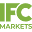
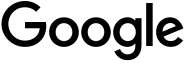

In [29]:
r.text


ValueError: could not convert string to float: 'FREE'

# One final step

As a Colombian guy who wants to buy the game in the cheapest way possible; i want to see the difference between both stores and wheter if it's worth or not to buy the game in Turkey store or US store. To do so, let's just do a final request, let's ask what is the current price of 1 tuerky lyris in US dolar. 


A dolar is equal to 0.03026506 TRY


ValueError: could not convert string to float: 'FREE'

In [219]:

df.to_csv("../data/processed/games_data.csv", index=False)